In [1]:
import matplotlib
matplotlib.use('Agg')
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
from matplotlib import gridspec
import matplotlib.dates as mdates

import json
import tkp.db
import tkp.config
import logging
import csv
import time
import sys

import itertools
import pylab
import numpy as np
import pandas as pd
import scipy as sp
import healpy as hp
import datetime
import os
import glob
from astropy import units as u
from astropy.coordinates import SkyCoord, match_coordinates_sky
from astropy.io import fits
from astropy.wcs import WCS

from scipy import stats
from scipy.stats import chisquare

import numbers
import math
import scipy
from scipy.stats import norm
from scipy.stats import sem
from scipy import linspace
from scipy import pi,sqrt,exp
from scipy.special import erf
from scipy.optimize import curve_fit
from scipy import asarray as ar,exp
from scipy import interpolate, signal

import pymc3 as pm
from scipy.stats import norm

from scipy import linspace
from scipy import pi,sqrt,exp
from scipy.special import erf

from matplotlib.ticker import NullFormatter
from matplotlib.font_manager import FontProperties

# plt.rcParams['font.size']=14
# plt.rcParams['axes.labelsize']='large'
# plt.rcParams['axes.titlesize']='large'
# pylab.rcParams['legend.loc'] = 'best'
matplotlib.rcParams['text.usetex'] = False

font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 14
       }
matplotlib.rc('font', **font)

%matplotlib inline

logging.basicConfig(level=logging.INFO)

import warnings
warnings.filterwarnings('ignore')

RuntimeError: module compiled against API version 0xc but this version of numpy is 0xa

/afhome/kuiack/newtrap/local/lib/python2.7/site-packages/pyfits/__init__.py:22: PyFITSDeprecationWarning: PyFITS is deprecated, please use astropy.io.fits
  PyFITSDeprecationWarning)  # noqa
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [2]:
def nsf(num, n=1):
    """n-Significant Figures"""
    numstr = ("{0:.%ie}" % (n-1)).format(num)
    return float(numstr)

def num_err(num, err, n=1):
    '''Return number rounded based on error'''
    return np.around(num,int(-(np.floor(np.log10(nsf(err,n=n)))))), nsf(err,n=n)

def clip(data, sigma=3):
    """Remove all values above a threshold from the array.
    Uses iterative clipping at sigma value until nothing more is getting clipped.
    Args:
        data: a numpy array
    """
    data = data[np.isfinite(data)]
    raveled = data.ravel()
    median = np.median(raveled)
    std = np.nanstd(raveled)
    newdata = raveled[np.abs(raveled-median) <= sigma*std]
    if len(newdata) and len(newdata) != len(raveled):
        return clip(newdata, sigma)
    else:
        return newdata

def pdf(x):
    return 1/sqrt(2*pi) * exp(-x**2/2)

def cdf(x):
    return (1 + erf(x/sqrt(2))) / 2

def skewnorm(x,e=0,w=1,a=0):
    t = (x-e) / w
    return 2 / w * pdf(t) * cdf(a*t)


def delta(shape):
    return (shape/pm.math.sqrt(1.0+shape**2.))


def muz(shape):
    return pm.math.sqrt(2./np.pi)*delta(shape) 

def skewness(shape):
    return (4.- np.pi)/2. * ((delta(shape)*pm.math.sqrt(2./np.pi))**3.)/(1.0-(2.0*delta(shape)**2.)/np.pi)**(3./2.)

def sigmaz(shape):
    return np.sqrt(1.-muz(shape)**2.)


def skew_mode(shape):
    return pm.math.sqrt(2.0/np.pi)*delta(shape) - \
        skewness(shape) * pm.math.sqrt(1.0 - (pm.math.sqrt(2.0/np.pi)*delta(shape))**2 )/2.0 - \
        (pm.math.sgn(shape) / 2.0) *( pm.math.exp (-(2.0*np.pi)/pm.math.abs_(shape)))


def sk_mode(loc,scale,shape):
    return loc + skew_mode(shape) * scale

def fit_lightcurve(y, draws=500,chains=4, njobs=4):
    with pm.Model() as model:

        (mu, sigma) = norm.fit(y)

        loc = pm.Normal("loc",mu, 20)
        scale = pm.HalfNormal("scale", sigma)
        skew = pm.Normal("skew", 0, 5)
        mode = pm.Deterministic("mode",sk_mode(loc,scale,skew))
        _y = pm.SkewNormal("y_dist",mu=loc, sd=scale,alpha=skew, observed=y)
        trace = pm.sample(draws=draws, chains=chains, njobs=njobs)
    mode = pm.summary(trace)[pm.summary(trace).index == "mode"]["mean"].values[0]
    mode_err = pm.summary(trace)[pm.summary(trace).index == "mode"]["sd"].values[0]
        
    return mode, mode_err

def distSquared(p0, p1):
    distance  = np.sqrt((p0[0] - p1[0,:])**2 + (p0[1] - p1[1,:])**2)
    if np.min(distance) < 3.0:
        return np.where(distance == np.min(distance))[0]
    else:
        return None
    
def pol2cart(rho, phi):
    x = rho * np.cos(phi)
    y = rho * np.sin(phi)
    return(x, y)

def retrieve_source(full_data, run_id):
    source_df = full_data[(full_data.runcatid == run_id)]
    
#     source_df = source_df.groupby('taustart_ts', as_index=False)
    source_df.set_index(source_df.taustart_ts, inplace=True)
    return source_df.sort_index()


def plot_lightcurve(full_data, run_id, ion_sub=False, roll_len = 1*60, roll_type = 'triang', stdout=True):

    source_df = full_data[(full_data.runcatid == run_id)]
    if stdout:
        print source_df.wm_ra.iloc[0], source_df.wm_decl.iloc[0]

    pd.to_datetime(source_df.taustart_ts)
    source_df = source_df.groupby('taustart_ts', as_index=False).mean()
    source_df.set_index(source_df.taustart_ts, inplace=True)

    if ion_sub:
        rolling = source_df.f_int.rolling(roll_len, win_type=roll_type)
        source_df.f_int = source_df.f_int-rolling.mean()


#     plt.rcParams['font.size']=16
#     plt.rcParams['axes.labelsize']='large'
#     plt.rcParams['axes.titlesize']='large'
#     pylab.rcParams['legend.loc'] = 'best'

    ylim = [np.nanmean(source_df.f_int)-6.0*np.nanstd(source_df.f_int),
            np.nanmean(source_df.f_int)+10.0*np.nanstd(source_df.f_int)]



    myFmt = mdates.DateFormatter('%H:%M')
    source_df["taustart_ts"] = pd.to_datetime(source_df["taustart_ts"])
    obs_dates = np.unique([100*x.month+x.day for x in source_df["taustart_ts"]])

    n_hours = np.array([]) 
    for i in obs_dates:
        index = (100*pd.DatetimeIndex(source_df["taustart_ts"]).month+pd.DatetimeIndex(source_df["taustart_ts"]).day == i)# & (source_df.extract_type == 0)
        n_hours = np.append(n_hours, len(np.unique(pd.DatetimeIndex(source_df["taustart_ts"][index]).hour)))
    hour_ratio = [i/n_hours.sum() for i in n_hours ]
    gs_ratio = np.append((hour_ratio)/min(hour_ratio),1)

    gs = gridspec.GridSpec(1, len(obs_dates)+1, width_ratios=gs_ratio) 

    figcount = 0
    figure = plt.figure(figsize=(4*len(obs_dates),6))

    for i in obs_dates:
        index = (100*pd.DatetimeIndex(source_df["taustart_ts"]).month+pd.DatetimeIndex(source_df["taustart_ts"]).day == i)# & (source_df.extract_type == 0)
        ax = plt.subplot(gs[figcount])
        ax.locator_params(nticks=6)
        ax.errorbar(source_df["taustart_ts"].values[index],
                    source_df["f_int"].values[index],
                    yerr=source_df["f_int_err"].values[index],
                    fmt=".",c="#1f77b4",ecolor="#ff7f0e")

        if figcount > 0:
            ax.set_yticks([])
        if figcount ==0:
            plt.ylabel("Flux [Jy]")
            ax.yaxis.set_ticks_position('left')
        if stdout:
            print source_df["taustart_ts"].values[index][0]
        plt.annotate("{}-{}".format(pd.DatetimeIndex(source_df["taustart_ts"].values[index]).day[0],
                                    pd.DatetimeIndex(source_df["taustart_ts"].values[index]).month[0]),
                                    xy=(0.95,0.95), xycoords='axes fraction',
                                    horizontalalignment='right', verticalalignment='top',fontsize=16)

        plt.xticks(rotation=90)
        ax.set_ylim(ylim)
        ax.xaxis.set_major_formatter(myFmt)
        figcount+=1

    hist_index = np.isfinite(source_df["f_int"]) #& (source_df.extract_type == 0)
    plt.subplot(gs[figcount])
    (mu, sigma) = norm.fit(source_df["f_int"].iloc[hist_index].values)
    n, bins, patches   =  plt.hist(source_df["f_int"].values[hist_index],
                                   bins=100,normed=1, orientation='horizontal',facecolor="#1f77b4")
    y = mlab.normpdf( bins, mu, sigma)
    if stdout:
        print "Gaus fit: mu {}, sigma {}".format(round(mu,3),round(sigma,3))
    
    l = plt.plot(y,bins,'r--', linewidth=2)
    plt.annotate("Total N:\n{}".format(len(source_df["f_int"].values[hist_index])),
                                xy=(0.95,0.95), xycoords='axes fraction',
                                horizontalalignment='right', verticalalignment='top',fontsize=16)
    plt.yticks([])
    plt.ylim(ylim)
    plt.xticks(rotation=90)

    plt.subplots_adjust(wspace=0.1, hspace=0)
    return figure





In [3]:
aart = pd.read_csv("/home/kuiack/AARTFAAC_catalogue.csv")


#### Load all data


In [4]:

# /home/kuiack/TR_20160905_flux.csv

all_data_name = "/home/kuiack/TR_20160905_flux.csv"
data = pd.read_csv(all_data_name, infer_datetime_format=True)
data.taustart_ts = pd.to_datetime(data.taustart_ts)
dbname = "tr_20160905"

#### Source target

In [ ]:
[1, 2,235, 248, 241, 221]

In [8]:
# TR-1 Galaxy - 1 231
target_ra = 273.5
target_decl = 26.5

# TR-2 Galaxy - 2  245
# target_ra = 278.77
# target_decl = 32.7

# nearby QSO - 235
# target_ra = 275.31
# target_decl = 22.85

# nearby radio source - 248
# target_ra = 280.01
# target_decl = 24.04

# nearby QSO - 241
# target_ra = 278.21
# target_decl = 28.56

# # nearby QSO - 221
# target_ra = 267.94
# target_decl = 29.84

# # herc - 196 197
# # target_ra = 252.77
# # target_decl = 5.0

# # 3c380 4 240
# target_ra = 277.48
# target_decl = 48.65


radius = 1

IDS = np.unique(data[(data.ra > target_ra-radius) &  (data.ra < target_ra+radius) &
                     (data.decl > target_decl-radius) &  (data.decl < target_decl+radius) ].runcatid )

print IDS

[  1 231]


In [9]:
IDS = []
aart_flux = []

for i in range(len(aart)):


    target_ra = aart.iloc[i].ra
    target_decl = aart.iloc[i].decl

# target_ra = 311.
# target_decl = 50.


# target_ra = 148.56
# target_decl = 7.66

    radius = 0.5



# IDS = np.unique(data[(data.ra > target_ra-radius) &  (data.ra < target_ra+radius) &
#                      (data.decl > target_decl-radius) &  (data.decl < target_decl+radius) &
#                      (data.extract_type == 2)].runcatid )
    ID = np.unique(data[(data.ra > target_ra-radius) &  (data.ra < target_ra+radius) &
                     (data.decl > target_decl-radius) &  (data.decl < target_decl+radius) ].runcatid )
    try:
        print ID[0]
        IDS.append(ID[0])
        aart_flux.append(aart.iloc[i].f_int)
    except IndexError:
        continue 

45
2
159
152
187
126
268
80
79
196
129
3
317
112
168
174
304
203
110
309
144
5
294
55
80
207
9
139
148
250
135
115
122
127
300
134
130
4
157
284
118
253
307


### Plot individual source lightcurves 

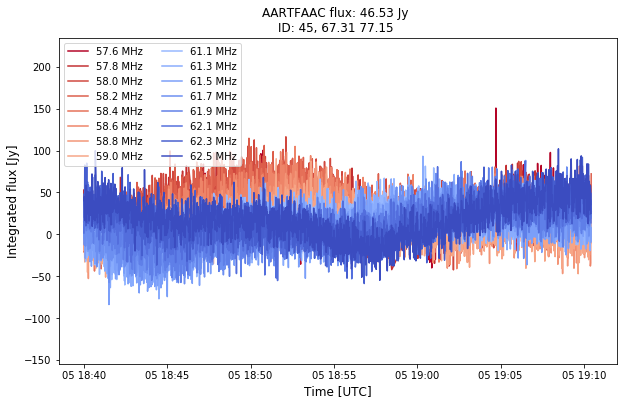

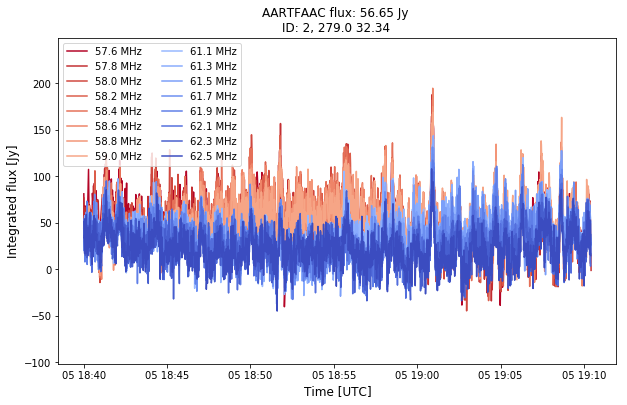

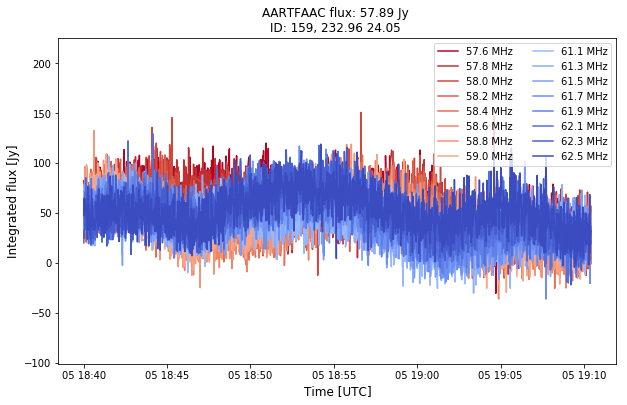

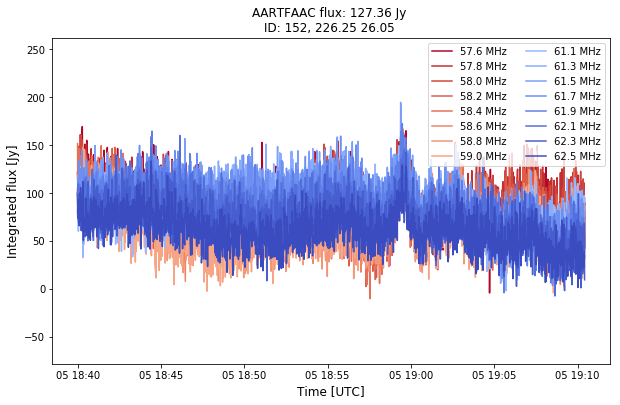

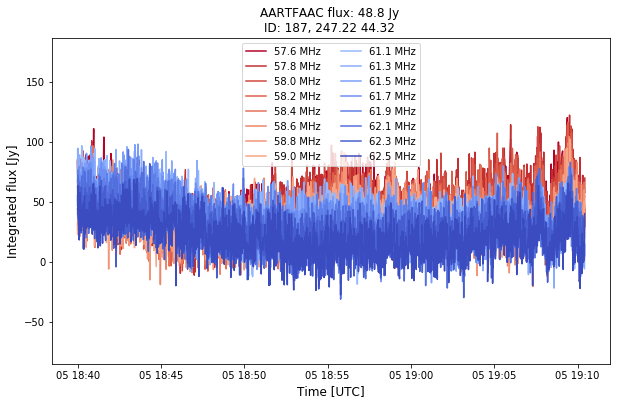

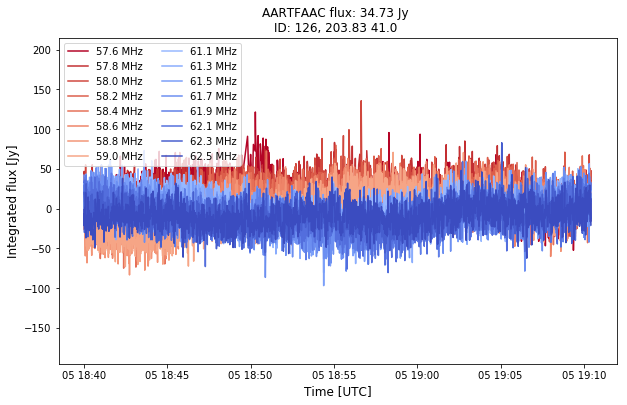

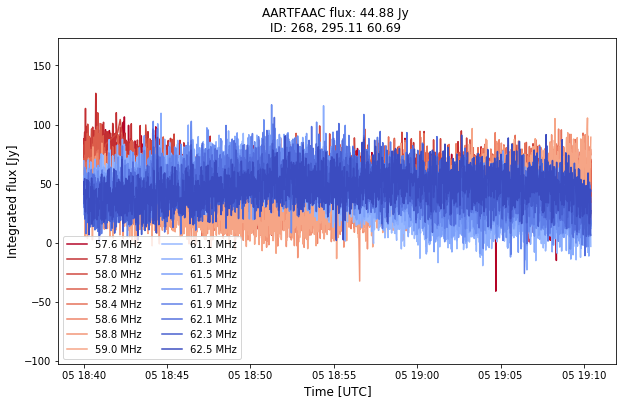

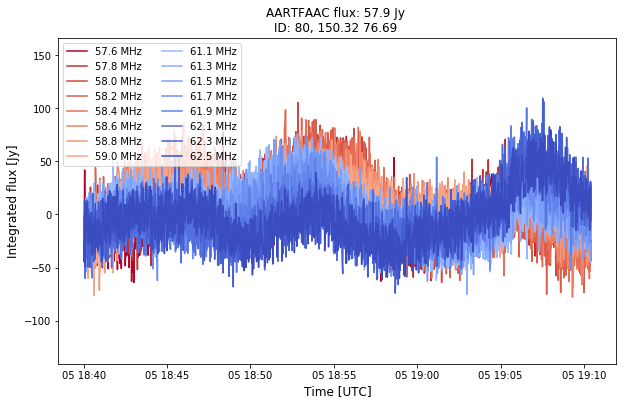

In [ ]:
%matplotlib inline



all_freq = np.unique(data.freq_eff)
scaled_all_freq = (all_freq - all_freq.min()) / all_freq.ptp()
colors = plt.cm.coolwarm(scaled_all_freq)


fig_n =0

for _ID in IDS: # np.unique(data.runcatid):

    source_df = retrieve_source(data, _ID)
    n_c = 0
    for freq in all_freq:


        plt.figure(fig_n,figsize=(10,6))

        plt.errorbar(source_df.taustart_ts[(source_df.freq_eff == freq)].values,
                     source_df.f_int[(source_df.freq_eff == freq) ].values,
                     yerr = source_df.f_int_err[(source_df.freq_eff == freq) ].values,
                     fmt="-", color=colors[::-1][n_c],ecolor="white", label="{} MHz".format(round(freq/1e6,1)))

        n_c+=1

    
    

    plt.title("AARTFAAC flux: {} Jy \nID: {}, {} {} ".format(aart_flux[fig_n],_ID,
                                                            round(np.nanmean(source_df.ra),2),
                                                            round(np.nanmean(source_df.decl),2) ))
    plt.ylabel("Integrated flux [Jy]")
    plt.legend(ncol=2)


    plt.xlabel("Time [UTC]")
    plt.show()
    fig_n +=1

### Measure Burst DM from delay 

In [6]:
n_c = 0
fig_n = 0
step=0.001 # data sampling in seconds 

delay = []


burst = data[(data.runcatid == 1)  &
            (data.taustart_ts > datetime.datetime(year=2016,day=5, month=9, hour=18,minute=50,second=6)) & 
            (data.taustart_ts < datetime.datetime(year=2016,day=5, month=9, hour=18,minute=51,second=16))]

# burst = data[(data.runcatid == 2) &
#             (data.taustart_ts > datetime.datetime(year=2016,day=5, month=9, hour=19,minute=0,second=30)) & 
#             (data.taustart_ts < datetime.datetime(year=2016,day=5, month=9, hour=19,minute=2,second=0))]
burst.set_index(burst.taustart_ts, inplace=True)
burst = burst.sort_index()
burst["timestep"] = [x.timestamp() for x in burst.taustart_ts]




all_freq = np.unique(data.freq_eff)
scaled_all_freq = (all_freq - all_freq.min()) / all_freq.ptp()
colors = plt.cm.coolwarm(scaled_all_freq)


start = []
end = [] 
for freq in all_freq[::-1]:
    start.append(np.min(burst.timestep[(burst.freq_eff == freq)].values))
    end.append(np.max(burst.timestep[(burst.freq_eff == freq)].values))

xnew = np.arange(np.max(start),np.min(end), step)



#     plt.subplot(211)


_source_flux = burst.f_int[(burst.freq_eff == all_freq[-1]) ].values


fa = interpolate.interp1d(burst.timestep[(burst.freq_eff == all_freq[-1])].values, 
                          _source_flux)
roll_n = 0
i = 100

# I think this imposes a linear delay as a function of frequency, 
# perhaps this should be calculated more robustly using DM function.
roll = i*np.array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,
                   18.,  19.,  20.,  21.,  22.,  23.,  24.,  25.], dtype=int)
_dm = 0


for trial in range(1000):
delay = []
roll_n = 0
fig_n =0
n_c = 0
for freq in all_freq[::-1]:

    _source_flux = burst.f_int[(burst.freq_eff == freq) ].values
    _source_fluxerr = burst.f_int_err[(burst.freq_eff == freq) ].values

    _source_flux = np.random.normal(loc = _source_flux,
                                    scale = _source_fluxerr)

    fb = interpolate.interp1d(burst.timestep[(burst.freq_eff == freq)].values, 
                              _source_flux)    


    plt.figure(333,figsize=(8,6))
    ax = plt.subplot(111)

    roll_step = np.array(get_delay(freq/1e6,62.5,_dm)/step,dtype=int)
    
    xaxis = [datetime.datetime.utcfromtimestamp(x) for x in xnew]
    ax.errorbar(xaxis,np.roll(fb(xnew),roll_step), lw=1,
                 color=colors[n_c], label="{} MHz".format(round(freq/1e6,1)))



    delay.append(np.argmax(signal.correlate(fa(xnew),fa(xnew), mode="same")) \
                 - np.argmax(signal.correlate(fa(xnew),np.roll(fb(xnew),roll_step), mode="same"))  )
 
    roll_n += 1


    n_c+=1

myFmt = mdates.DateFormatter('%H:%M:%S')
ax.xaxis.set_major_formatter(myFmt)
ax.set_ylim([-100,250]) 
plt.ylabel("Integrated flux [Jy]")
plt.legend(ncol=2)

plt.xlim([datetime.datetime(year=2016,day=5, month=9, hour=18,minute=50,second=0),
          datetime.datetime(year=2016,day=5, month=9, hour=18,minute=51,second=35)])


plt.xlabel("Time [UTC H:M:S]")
plt.tight_layout()
# plt.savefig("/home/kuiack/mag_figs/TR_1.png")


plt.figure(figsize=(8,6))
plt.plot(np.array(delay)*step,all_freq[::-1]/1e6,"o", 
         label="DM: {}".format(_dm))
plt.ylabel("Frequency [MHz]")
plt.xlabel("Delay from highest subband [s]")
plt.legend()
plt.show()

print stats.ks_2samp(delay, delay_zero)

D, p = stats.ks_2samp(delay, delay_zero)

if D > 1.517*np.sqrt(float(16+16)/(16*16)):
    print "Distributions not the same at confidence 0.01"


IndentationError: expected an indented block (<ipython-input-6-c34eb59ab4a3>, line 56)

In [5]:
def get_delay(f1,f2,DM):
    return 4.15*10**3*(f1**(-2)-f2**(-2))*DM


def get_DM(f1,f2,dt):
    return float(dt)/4.15*10**3*(f1**(-2)-f2**(-2))



0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900
5000
5100
5200
5300
5400
5500
5600
5700
5800
5900
6000
6100
6200
6300
6400
6500
6600
6700
6800
6900
7000
7100
7200
7300
7400
7500
7600
7700
7800
7900
8000
8100
8200
8300
8400
8500
8600
8700
8800
8900
9000
9100
9200
9300
9400
9500
9600
9700
9800
9900


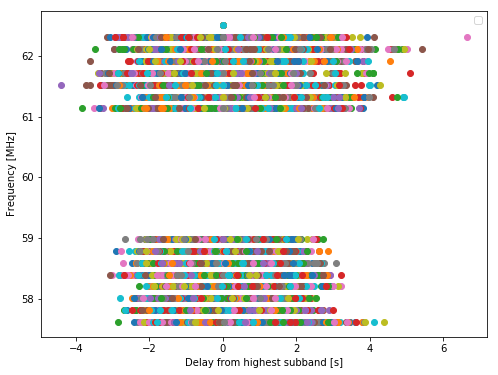

NameError: name 'delay_zero' is not defined

In [12]:
n_c = 0
fig_n = 0
step=0.001 # data sampling in seconds 

delay = []


burst = data[(data.runcatid == 1)  &
            (data.taustart_ts > datetime.datetime(year=2016,day=5, month=9, hour=18,minute=50,second=6)) & 
            (data.taustart_ts < datetime.datetime(year=2016,day=5, month=9, hour=18,minute=51,second=16))]

# burst = data[(data.runcatid == 2) &
#             (data.taustart_ts > datetime.datetime(year=2016,day=5, month=9, hour=19,minute=0,second=30)) & 
#             (data.taustart_ts < datetime.datetime(year=2016,day=5, month=9, hour=19,minute=2,second=0))]
burst.set_index(burst.taustart_ts, inplace=True)
burst = burst.sort_index()
burst["timestep"] = [x.timestamp() for x in burst.taustart_ts]




all_freq = np.unique(data.freq_eff)
scaled_all_freq = (all_freq - all_freq.min()) / all_freq.ptp()
colors = plt.cm.coolwarm(scaled_all_freq)


start = []
end = [] 
for freq in all_freq[::-1]:
    start.append(np.min(burst.timestep[(burst.freq_eff == freq)].values))
    end.append(np.max(burst.timestep[(burst.freq_eff == freq)].values))

xnew = np.arange(np.max(start),np.min(end), step)



#     plt.subplot(211)


_source_flux = burst.f_int[(burst.freq_eff == all_freq[-1]) ].values


fa = interpolate.interp1d(burst.timestep[(burst.freq_eff == all_freq[-1])].values, 
                          _source_flux)
roll_n = 0
i = 100

# I think this imposes a linear delay as a function of frequency, 
# perhaps this should be calculated more robustly using DM function.
roll = i*np.array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,
                   18.,  19.,  20.,  21.,  22.,  23.,  24.,  25.], dtype=int)
_dm = 0

delay = np.nan*np.ones([16,10000])
delay_freq = np.nan*np.ones([16,10000])

for trial in range(10000):
    if trial % 100 == 0:
        print trial
        

    roll_n = 0
    fig_n =0
    n_c = 0
    
    i = 0
    
    _source_flux = burst.f_int[(burst.freq_eff == all_freq[-1]) ].values
    _source_fluxerr = burst.f_int_err[(burst.freq_eff == all_freq[-1])].values

    fa = interpolate.interp1d(burst.timestep[(burst.freq_eff == all_freq[-1])].values, 
                          _source_flux)
    
    delay[i, trial] = 0
    delay_freq[i, trial] = all_freq[::-1][0]
    
    i = 1
    for freq in all_freq[::-1][1:]:

        _source_flux = burst.f_int[(burst.freq_eff == freq) ].values
        _source_fluxerr = burst.f_int_err[(burst.freq_eff == freq) ].values

        _source_flux = np.random.normal(loc = _source_flux,
                                        scale = _source_fluxerr)

        fb = interpolate.interp1d(burst.timestep[(burst.freq_eff == freq)].values, 
                                  _source_flux)    


        delay_freq[i, trial] = freq

        delay[i, trial] = np.argmax(signal.correlate(fa(xnew),fa(xnew), mode="same")) \
                     - np.argmax(signal.correlate(fa(xnew),np.roll(fb(xnew),0), mode="same"))

        roll_n += 1
 
        i += 1
        n_c += 1

plt.figure(figsize=(8,6))
plt.plot(np.array(delay)*step,np.array(delay_freq)/1e6,"o")#, 
         #label="DM: {}".format(_dm))
plt.ylabel("Frequency [MHz]")
plt.xlabel("Delay from highest subband [s]")
plt.legend()
plt.show()

print stats.ks_2samp(delay, delay_zero)

D, p = stats.ks_2samp(delay, delay_zero)

if D > 1.517*np.sqrt(float(16+16)/(16*16)):
    print "Distributions not the same at confidence 0.01"


In [20]:
from scipy.stats import gaussian_kde
x = np.array(delay)*step 
y = np.array(delay_freq)/1e6

xy = np.vstack([x,y])
z = gaussian_kde(xy)(xy)

idx = z.argsort()
x, y, z = x[idx], y[idx], z[idx]

fig, ax = plt.subplots(figsize=(6,6))
ax.scatter(x, y, c=z, s=50, edgecolor='')
plt.show() 

IndexError: index 29 is out of bounds for axis 0 with size 16

In [ ]:
def get_delay(f1,DM):
    return 4.15*10**3*(f1**(-2)-f1[0]**(-2))*DM

def get_DM(f1,f2,dt):
    return float(dt)/4.15*10**3*(f1**(-2)-f2**(-2))


N  = 1000 trials 


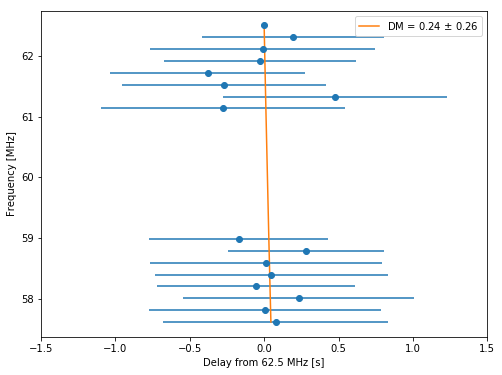

In [13]:
print "N  = 1000 trials "

plt.figure(figsize=(8,6))
plt.errorbar(np.nanmean(delay, axis=1)*step, 
             np.nanmean(delay_freq, axis=1)/1e6,
             xerr = np.nanstd(delay, axis=1)*step, fmt="o")

DM, DM_err = curve_fit(get_delay, np.linspace(np.nanmean(delay_freq, axis=1)[0]/1e6,
            np.nanmean(delay_freq, axis=1)[-1]/1e6, 16), 
          np.nanmean(delay, axis=1)*step )


# plt.plot(get_delay(all_freq[::-1]/1e6, DM+DM_err[0]), 
#          all_freq[::-1]/1e6, c="k"  )

# plt.plot(get_delay(all_freq[::-1]/1e6, DM-DM_err[0]), 
#          all_freq[::-1]/1e6, c="k"  )

plt.plot(get_delay(all_freq[::-1]/1e6, DM), 
         all_freq[::-1]/1e6,
         label="DM = {} "r"$\pm$"" {}".format(round(DM,2), round(DM_err,2))  )


plt.ylabel("Frequency [MHz]")
plt.xlabel("Delay from 62.5 MHz [s]")
plt.xlim([-1.5,1.5])
plt.legend()
plt.savefig("/home/kuiack/mag_figs/DM_measure.png")

N  = 1000 trials 


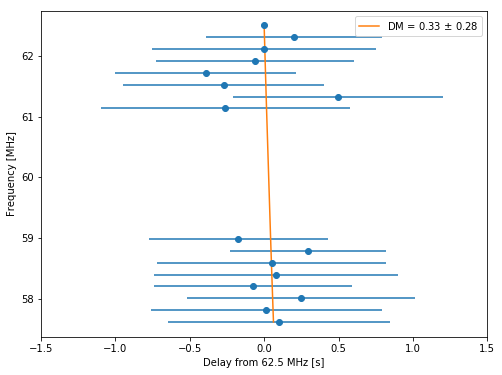

In [112]:
print "N  = 1000 trials "

plt.figure(figsize=(8,6))
plt.errorbar(np.nanmean(delay, axis=1)*step, 
             np.nanmean(delay_freq, axis=1)/1e6,
             xerr = np.nanstd(delay, axis=1)*step, fmt="o")

DM, DM_err = curve_fit(get_delay, np.linspace(np.nanmean(delay_freq, axis=1)[0]/1e6,
            np.nanmean(delay_freq, axis=1)[-1]/1e6, 16), 
          np.nanmean(delay, axis=1)*step )


# plt.plot(get_delay(all_freq[::-1]/1e6, DM+DM_err[0]), 
#          all_freq[::-1]/1e6, c="k"  )

# plt.plot(get_delay(all_freq[::-1]/1e6, DM-DM_err[0]), 
#          all_freq[::-1]/1e6, c="k"  )

plt.plot(get_delay(all_freq[::-1]/1e6, DM), 
         all_freq[::-1]/1e6,
         label="DM = {} "r"$\pm$"" {}".format(round(DM,2), round(DM_err,2))  )


plt.ylabel("Frequency [MHz]")
plt.xlabel("Delay from 62.5 MHz [s]")
plt.xlim([-1.5,1.5])
plt.legend()
plt.savefig("/home/kuiack/mag_figs/DM_measure.png")

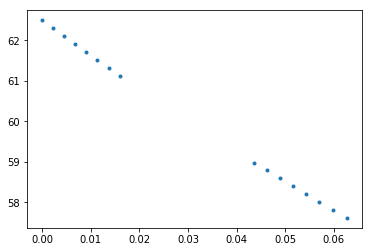

In [98]:
plt.plot(get_delay(all_freq[::-1]/1e6, -0.33366743), all_freq[::-1]/1e6, "." )

In [85]:
np.linspace(np.nanmean(delay_freq, axis=1)[0]/1e6,
            np.nanmean(delay_freq, axis=1)[-1]/1e6, 16)

array([ 62.5      ,  62.1744792,  61.8489584,  61.5234376,  61.1979168,
        60.872396 ,  60.5468752,  60.2213544,  59.8958336,  59.5703128,
        59.244792 ,  58.9192712,  58.5937504,  58.2682296,  57.9427088,
        57.617188 ])

In [100]:
curve_fit(get_delay, np.linspace(np.nanmean(delay_freq, axis=1)[0]/1e6,
            np.nanmean(delay_freq, axis=1)[-1]/1e6, 16), 
          np.nanmean(delay, axis=1)*step )

(array([ 0.33366743]), array([[ 0.2796184]]))

In [70]:
4.15*10**3*((62.)**(-2)-(np.nanmean(delay_freq, axis=1)[1:]/1e6)**(-2))*20.

array([ 0.21066681,  0.07598135, -0.05998074, -0.19723565, -0.33580267,
       -0.47569283, -0.61692593, -2.2642648 , -2.42304169, -2.583409  ,
       -2.74539136, -2.90900382, -3.0742717 , -3.24121741, -3.40986375])

In [72]:
4.15*10**3*((np.nanmean(delay_freq, axis=1)[0]/1e6)**(-2)-(np.nanmean(delay_freq, axis=1)[1:]/1e6)**(-2))*20.

array([-0.13342476, -0.26811022, -0.40407231, -0.54132722, -0.67989424,
       -0.8197844 , -0.9610175 , -2.60835637, -2.76713327, -2.92750057,
       -3.08948293, -3.25309539, -3.41836327, -3.58530898, -3.75395533])

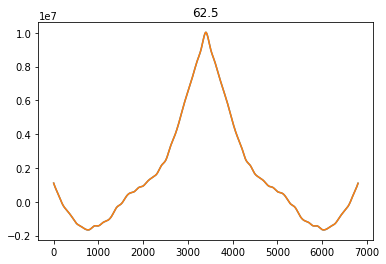

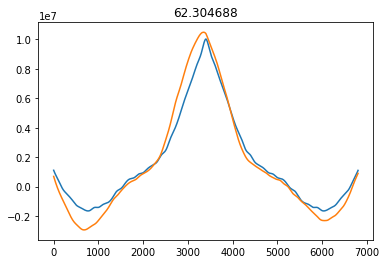

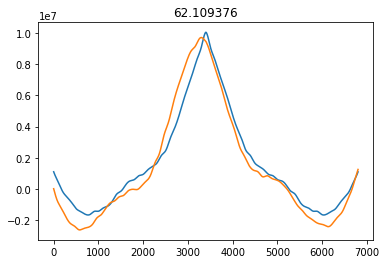

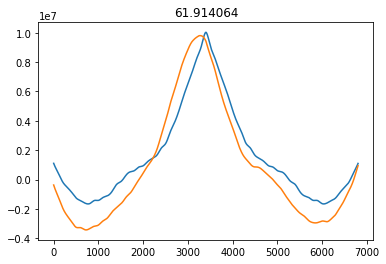

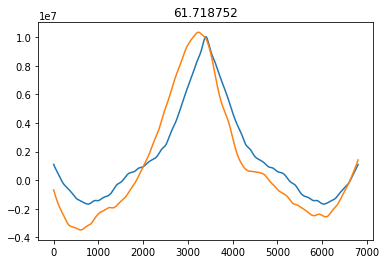

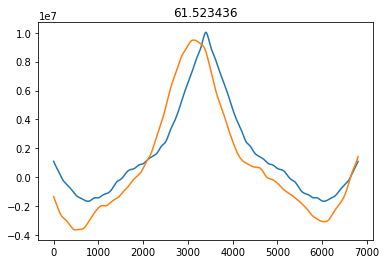

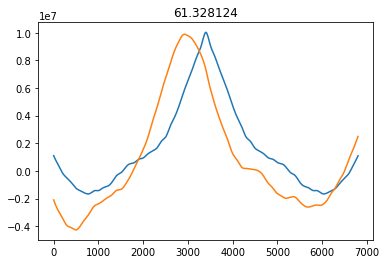

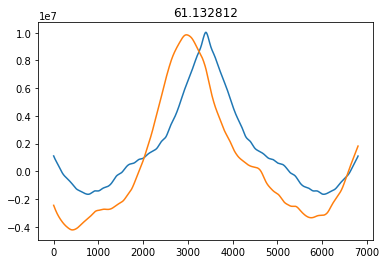

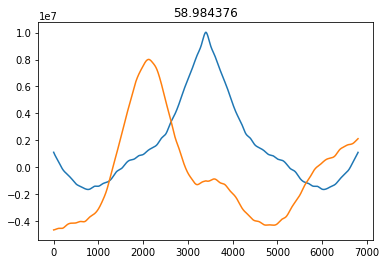

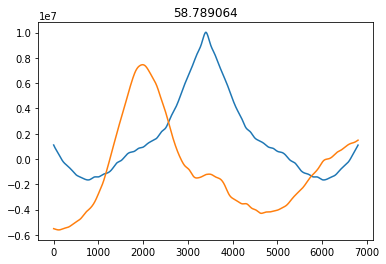

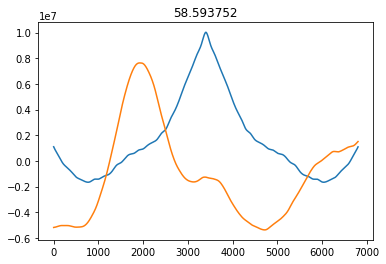

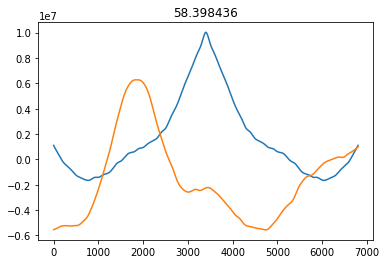

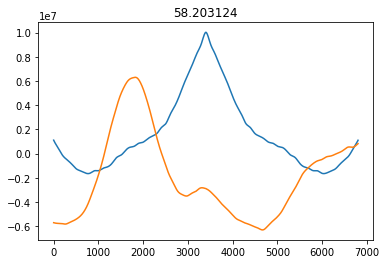

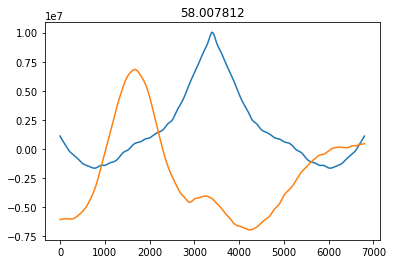

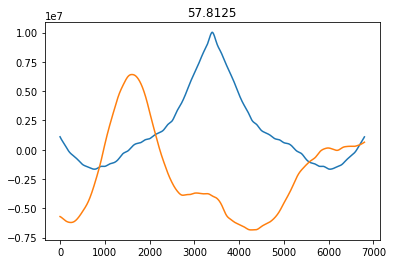

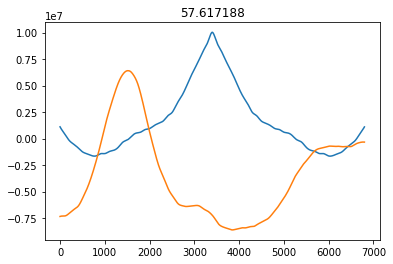

In [85]:
num = 0
f_num = -2

_dm = 100

for i in range(16):
    _source_flux = burst.f_int[(burst.freq_eff == all_freq[::-1][i]) ].values


    fb = interpolate.interp1d(burst.timestep[(burst.freq_eff == all_freq[::-1][i])].values, 
                              _source_flux)    

    roll_step = np.array(get_delay(all_freq[::-1][i]/1e6,62.5,_dm)/step,dtype=int)
    
    
    xaxis = [datetime.datetime.utcfromtimestamp(x) for x in xnew]
    plt.figure()
    plt.title(all_freq[::-1][i]/1e6)
    plt.plot(signal.correlate(fa(xnew),fa(xnew), mode="same"))
    plt.plot(signal.correlate(fa(xnew),np.roll(fb(xnew),roll_step), mode="same"))


# print(np.argmax(signal.correlate(fa(xnew),fa(xnew), mode="same")) - \
#       np.argmax(signal.correlate(fa(xnew),np.roll(fb(xnew),roll[num]), mode="same"))) *step



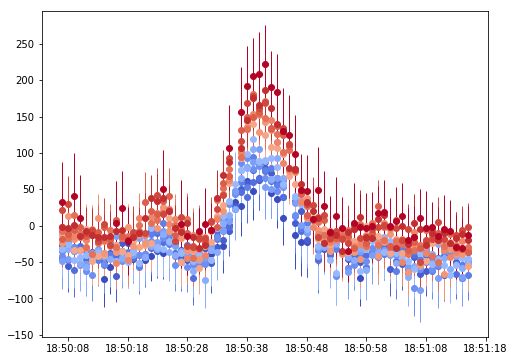

In [9]:
%matplotlib inline

burst = data[(data.runcatid == 1)  &
            (data.taustart_ts > datetime.datetime(year=2016,day=5, month=9, hour=18,minute=50,second=6)) & 
            (data.taustart_ts < datetime.datetime(year=2016,day=5, month=9, hour=18,minute=51,second=16))]

n_c = 0
all_freq = np.unique(data.freq_eff)
scaled_all_freq = (all_freq - all_freq.min()) / all_freq.ptp()
colors = plt.cm.coolwarm(scaled_all_freq)

for freq in all_freq[::-1]:
    
    _source_flux = burst.f_int[(burst.freq_eff == freq) ].values
    _source_fluxerr = burst.f_int_err[(burst.freq_eff == freq) ].values
    _source_time = burst.taustart_ts[(burst.freq_eff == freq) ].values


    plt.figure(333,figsize=(8,6))
    ax = plt.subplot(111)

    ax.errorbar(_source_time,_source_flux, yerr=_source_fluxerr , lw=1,fmt = "o",
                 color=colors[n_c], label="{} MHz".format(round(freq/1e6,1)))
    n_c += 1
plt.show()

In [10]:
np.random.normal(loc = _source_flux, 
                 scale = _source_fluxerr)

array([  1.54178016e+01,   2.50751573e+02,   7.64845436e+01,
         2.46230516e+01,  -3.91891034e+01,   7.28109374e+01,
         3.56200964e+01,  -6.48443591e+01,   4.91573741e+01,
        -5.15371020e+01,   1.34287322e+02,   4.93467964e+01,
        -4.44184228e+01,  -1.34216471e+01,  -2.67510839e-01,
        -1.96630828e+01,   2.20291287e+02,   1.46092031e+01,
        -1.23544197e+01,   2.69661283e+01,   4.16783636e+01,
         6.88712384e+01,   5.48956722e+01,   3.78667468e+01,
        -7.11583299e+01,   3.00069984e+02,   3.02817550e+01,
         6.43400215e+01,  -8.95081353e+01,   4.52519960e+01,
         6.91946737e+01,   2.12256894e+02,  -1.07578664e+02,
         6.94458186e+01,   1.26993148e+01,  -3.23139061e+00,
        -1.31628411e+02,  -7.28120387e-01,   4.74851735e+01,
        -2.57558140e+01,   2.98718024e+02,  -1.44234673e+01,
         2.26741086e+01,   6.84756775e+01,   6.52180941e+01,
         6.97374956e+01,  -2.74902474e+01,   2.23082964e+01,
        -7.78796279e+00,

In [11]:
# delay_neg = delay

# delay_pos = delay
delay_zero = delay

Power_divergenceResult(statistic=nan, pvalue=nan)
Ks_2sampResult(statistic=0.4375, pvalue=0.065668670952571229)


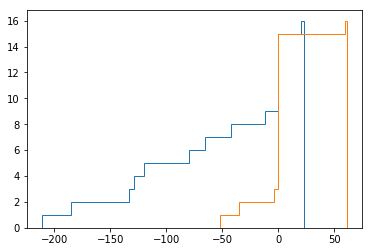

In [42]:
from scipy import stats
from scipy.stats import chisquare

print chisquare(delay, f_exp=delay_zero)
print stats.ks_2samp(delay, delay_zero)

_x = plt.hist(delay, cumulative=True, bins=100, histtype="step")

_x = plt.hist(delay_zero, cumulative=True, bins=100, histtype="step")
# _x = plt.hist(delay_neg, cumulative=True, bins=100, histtype="step")
# _x = plt.hist(delay_pos, cumulative=True, bins=100, histtype="step")

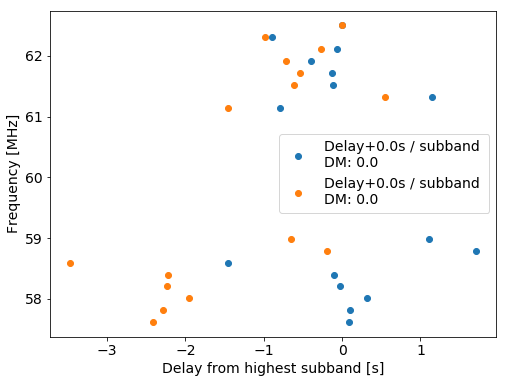

In [107]:
plt.figure(figsize=(8,6))
plt.plot(np.array(delay)*step,all_freq[::-1]/1e6,"o", label="Delay+{}s / subband \nDM: {}".format(step*i,
         round((step*i)/(4.15*10**3*(57.4**(-2)-61.5**(-2))),3)))

plt.plot(np.array(delay_neg)*step,all_freq[::-1]/1e6,"o", label="Delay+{}s / subband \nDM: {}".format(step*i,
         round((step*i)/(4.15*10**3*(57.4**(-2)-61.5**(-2))),3)))
plt.ylabel("Frequency [MHz]")
plt.xlabel("Delay from highest subband [s]")
plt.legend()


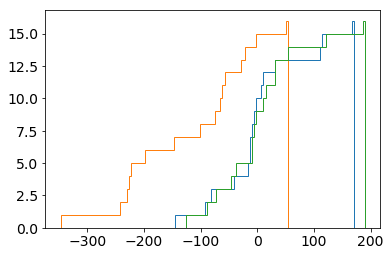

In [121]:
_x = plt.hist(delay, cumulative=True, bins=100,histtype="step")
_x = plt.hist(delay_neg, cumulative=True,bins=100, histtype="step")
_x = plt.hist(delay_pos, cumulative=True,bins=100, histtype="step")

## Plot burst

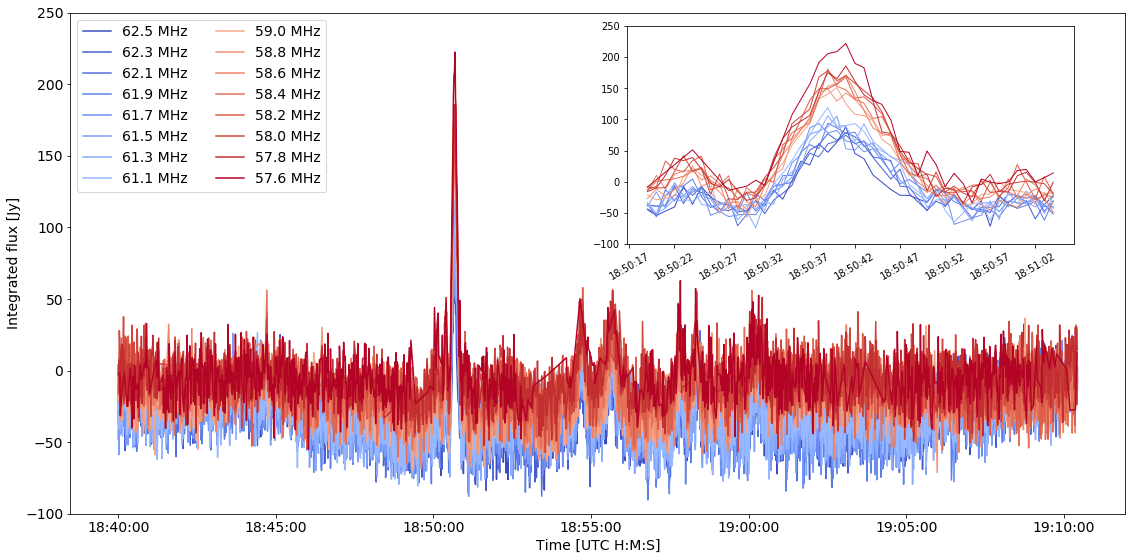

In [51]:
def add_subplot_axes(ax,rect):
    fig = plt.gcf()
    box = ax.get_position()
    width = box.width
    height = box.height
    inax_position  = ax.transAxes.transform(rect[0:2])
    transFigure = fig.transFigure.inverted()
    infig_position = transFigure.transform(inax_position)    
    x = infig_position[0]
    y = infig_position[1]
    width *= rect[2]
    height *= rect[3]  # <= Typo was here
    subax = fig.add_axes([x,y,width,height])
    x_labelsize = subax.get_xticklabels()[0].get_size()
    y_labelsize = subax.get_yticklabels()[0].get_size()
    x_labelsize *= rect[2]**0.5
    y_labelsize *= rect[3]**0.5
    subax.xaxis.set_tick_params(labelsize=x_labelsize, rotation=30)
    subax.yaxis.set_tick_params(labelsize=y_labelsize)
    return subax

# plt.rcParams['font.size']= 14
# plt.rcParams['axes.labelsize']='medium'
# plt.rcParams['axes.titlesize']='medium'
# pylab.rcParams['legend.loc'] = 'best'

font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 14
       }
matplotlib.rc('font', **font)


n_c = 0
fig_n = 0
fig =  plt.figure(figsize=(16,8))
ax = fig.add_subplot(111)
for freq in all_freq[::-1]:

    burst = data[(data.runcatid == 1) & (data.freq_eff == freq) ]
    
    burst.set_index(burst.taustart_ts, inplace=True)
    burst = burst.sort_index()

    xnew = [x.timestamp() for x in burst.taustart_ts]
    xaxis = [datetime.datetime.utcfromtimestamp(x) for x in xnew]

    ax.plot(xaxis, burst.f_int , c=colors[n_c], label="{} MHz".format(round(freq/1e6,1)))

    n_c += 1


myFmt = mdates.DateFormatter('%H:%M:%S')
ax.xaxis.set_major_formatter(myFmt)
ax.set_ylim([-100,250])
plt.ylabel("Integrated flux [Jy]")
plt.legend(loc="upper left",ncol=2)
plt.xlabel("Time [UTC H:M:S]")
# plt.tight_layout()


n_c = 0
fig_n = 0
step=0.01
delay = []

rect = [0.55,0.58,0.5,0.5]
ax1 = add_subplot_axes(ax,rect)


burst = data[(data.runcatid == 1) &
            (data.taustart_ts > datetime.datetime(year=2016,day=5, month=9, hour=18,minute=50,second=15)) & 
            (data.taustart_ts < datetime.datetime(year=2016,day=5, month=9, hour=18,minute=51,second=5))]

burst = burst.sort_index()
burst["timestep"] = [x.timestamp() for x in burst.taustart_ts]




all_freq = np.unique(data.freq_eff)
scaled_all_freq = (all_freq - all_freq.min()) / all_freq.ptp()
colors = plt.cm.coolwarm(scaled_all_freq)


start = []
end = [] 
for freq in all_freq[::-1]:
    start.append(np.min(burst.timestep[(burst.freq_eff == freq)].values))
    end.append(np.max(burst.timestep[(burst.freq_eff == freq)].values))
    
xnew = np.arange(np.max(start),np.min(end), step)



#     plt.subplot(211)
n_c = 0
fig_n = 0
step=0.01
delay = []

_source_flux = burst.f_int[(burst.freq_eff == all_freq[-1]) ].values


fa = interpolate.interp1d(burst.timestep[(burst.freq_eff == all_freq[-1])].values, 
                          _source_flux)
roll_n = 0
i = 0

roll = i*np.array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,
                   18.,  19.,  20.,  21.,  22.,  23.,  24.,  25.], dtype=int)


fig_n =0
for freq in all_freq[::-1]:
    
    _source_flux = burst.f_int[(burst.freq_eff == freq) ].values


    
    fb = interpolate.interp1d(burst.timestep[(burst.freq_eff == freq)].values, 
                              _source_flux)    


#     plt.figure(333,figsize=(8,6))
#     ax1 = plt.subplot(111)

    xaxis = [datetime.datetime.utcfromtimestamp(x) for x in xnew]
    ax1.errorbar(xaxis,np.roll(fb(xnew),roll[roll_n]), lw=1,
                 color=colors[n_c], label="{} MHz".format(round(freq/1e6,1)))
   


    delay.append(np.argmax(signal.correlate(fa(xnew),fa(xnew), mode="same")) \
                 - np.argmax(signal.correlate(fa(xnew),np.roll(fb(xnew),roll[roll_n]), mode="same"))  )
 
    roll_n += 1


    n_c+=1

myFmt = mdates.DateFormatter('%H:%M:%S')
ax1.xaxis.set_major_formatter(myFmt)
ax1.set_ylim([-100,250]) 
# plt.ylabel("Integrated flux [Jy]")
# plt.legend(ncol=2)

# plt.xlabel("Time [UTC H:M:S]")
plt.tight_layout()
plt.savefig("/home/kuiack/mag_figs/TR_1.pdf")


plt.show()


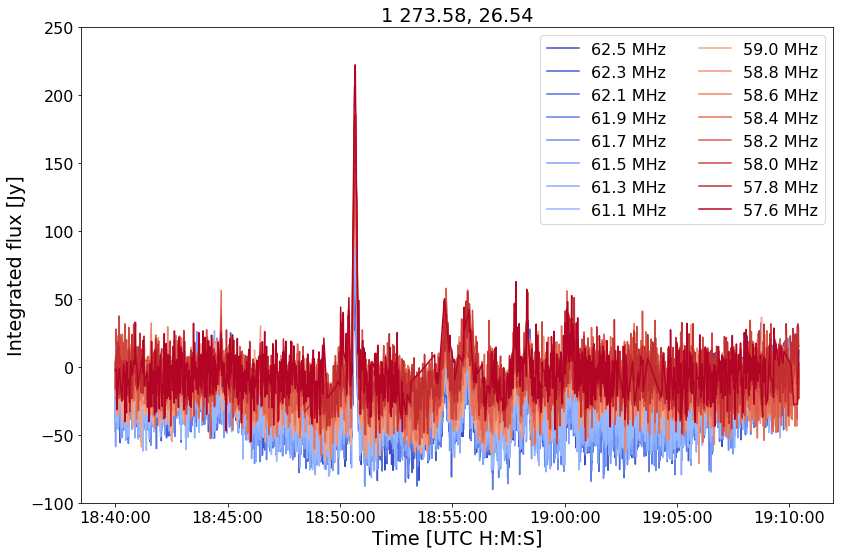

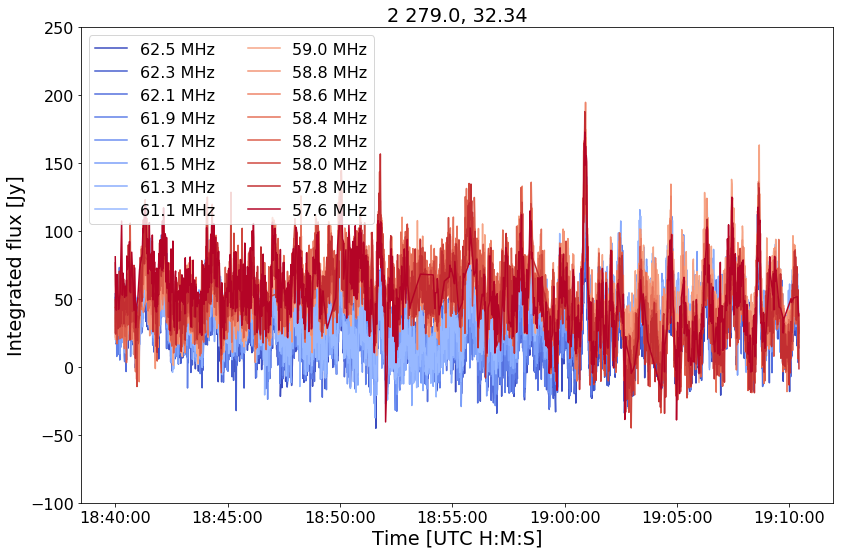

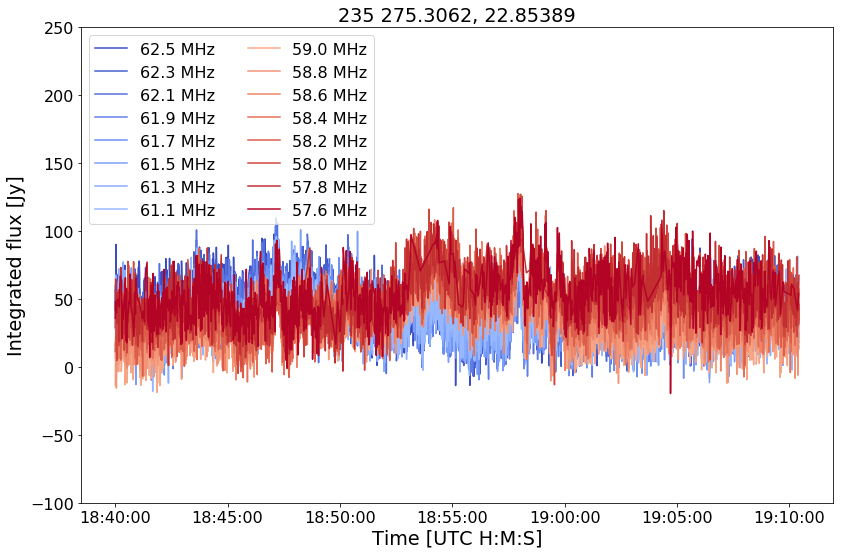

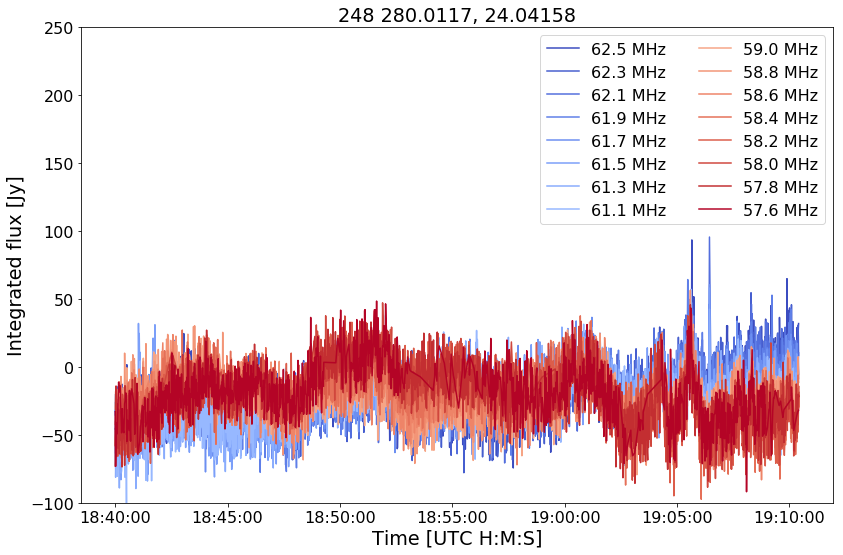

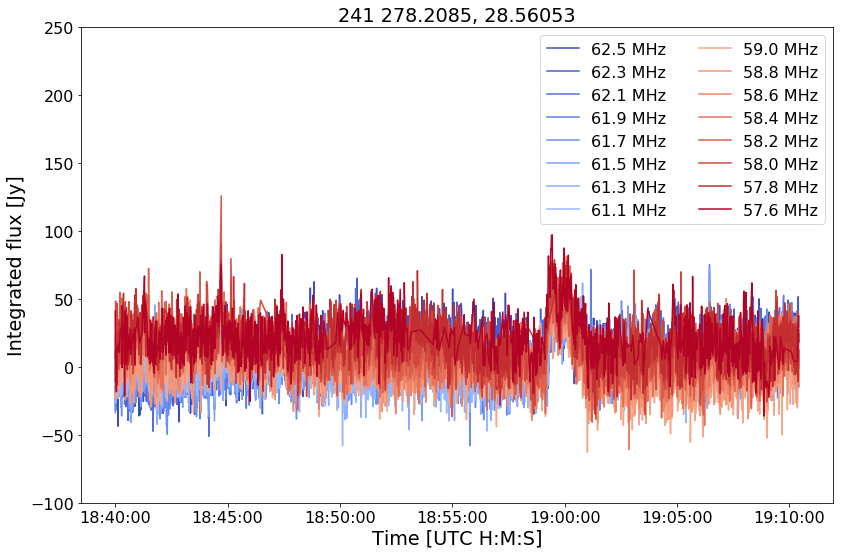

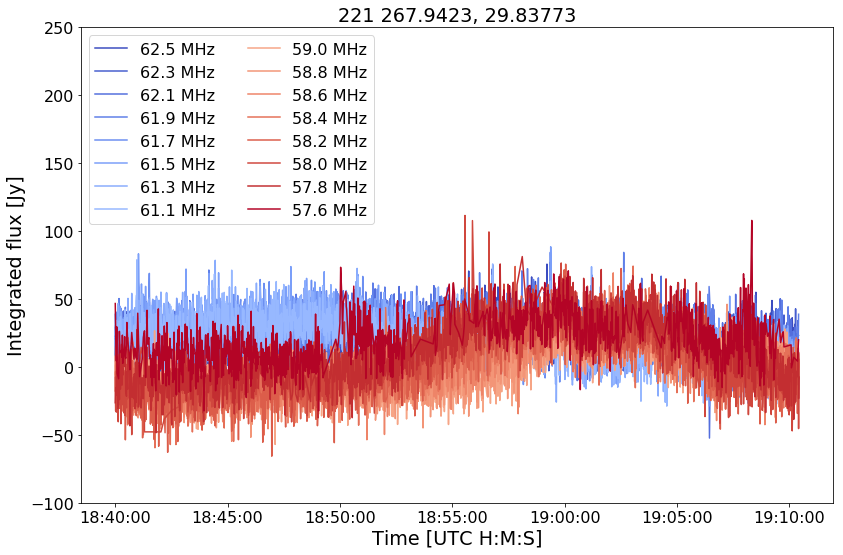

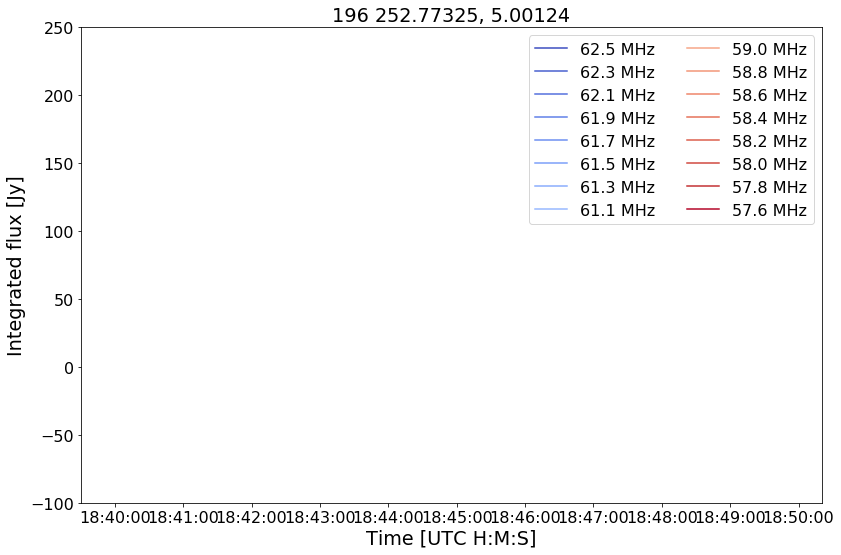

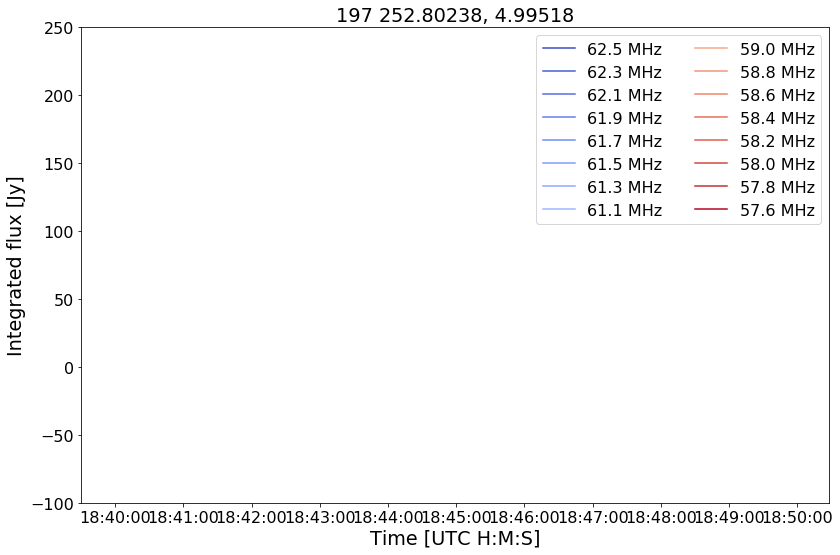

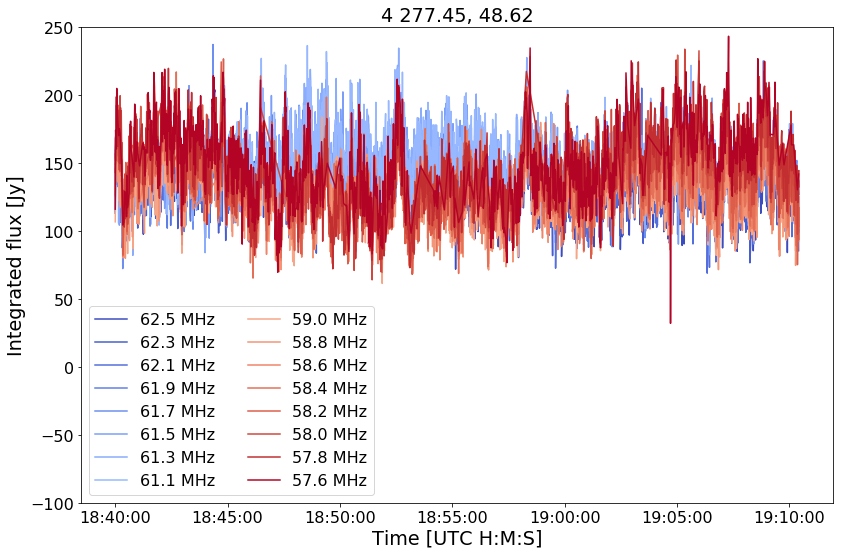

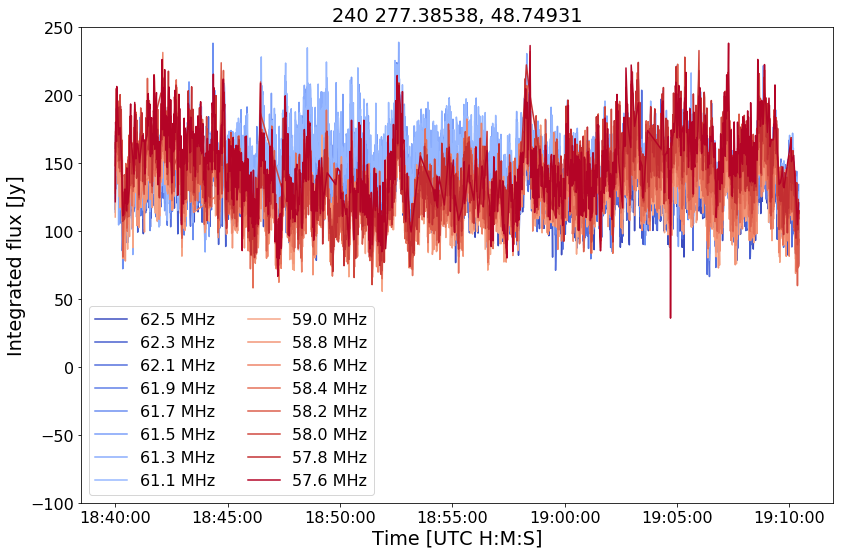

In [39]:
%matplotlib inline
n_c = 0





plt.rcParams['font.size']=16
plt.rcParams['axes.labelsize']='large'
plt.rcParams['axes.titlesize']='large'
pylab.rcParams['legend.loc'] = 'best'
matplotlib.rcParams['text.usetex'] = False

all_freq = np.unique(data.freq_eff)
scaled_all_freq = (all_freq - all_freq.min()) / all_freq.ptp()
colors = plt.cm.coolwarm(scaled_all_freq)


for _ID in [1, 2,235, 248, 241, 221, 196, 197, 4, 240]:
    n_c = 0 
    plt.figure(figsize=(12,8))
    for freq in all_freq[::-1]:

        ax = plt.subplot(111)
        burst = data[(data.runcatid == _ID) & (data.freq_eff == freq) ]# &
    #                   (data.taustart_ts > datetime.datetime(year=2016,day=5, month=9, hour=19,minute=0,second=0)) & 
    #                   (data.taustart_ts < datetime.datetime(year=2016,day=5, month=9, hour=19,minute=2,second=0))]
        burst.set_index(burst.taustart_ts, inplace=True)
        burst = burst.sort_index()


        xnew = [x.timestamp() for x in burst.taustart_ts]
        xaxis = [datetime.datetime.utcfromtimestamp(x) for x in xnew]

        ax.plot(xaxis, burst.f_int , c=colors[n_c], label="{} MHz".format(round(freq/1e6,1)))

        n_c += 1


    myFmt = mdates.DateFormatter('%H:%M:%S')
    ax.xaxis.set_major_formatter(myFmt)
    ax.set_ylim([-100,250])
    plt.ylabel("Integrated flux [Jy]")
    plt.legend(ncol=2)
    plt.title(str(_ID)+" "+str(burst.ra.median())+", "+str(burst.decl.median())) 
    plt.xlabel("Time [UTC H:M:S]")
    plt.tight_layout()
plt.show()

# plt.savefig("/home/kuiack/TR-2_burstlightcurve.png")

273.58

## Measure spectral index 

In [25]:
burst_df = pd.DataFrame([])


for freq in all_freq[::-1]:

    burst = data[(data.runcatid == 1) & (data.freq_eff == freq)  &
                  (data.taustart_ts > datetime.datetime(year=2016,day=5, month=9, hour=18,minute=50,second=40)) & 
                  (data.taustart_ts < datetime.datetime(year=2016,day=5, month=9, hour=18,minute=51,second=0))]
    burst.set_index(burst.taustart_ts, inplace=True)
    burst = burst.sort_index()

    burst_df[str(freq)] = burst.f_int

        

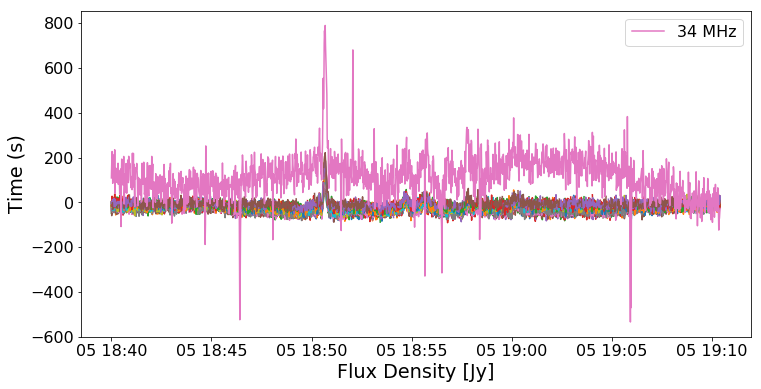

In [12]:


plt.figure(figsize=(12,6))
plt.plot(burst_df)

plt.plot(burst_df.index,linear(34000000, np.array(linearindexes)[:,0],np.array(linearindexes)[:,1]), label="34 MHz")
plt.xlabel("Flux Density [Jy]")
plt.ylabel("Time (s)")
plt.legend()

ValueError: x and y must have same first dimension, but have shapes (16,) and (294,)

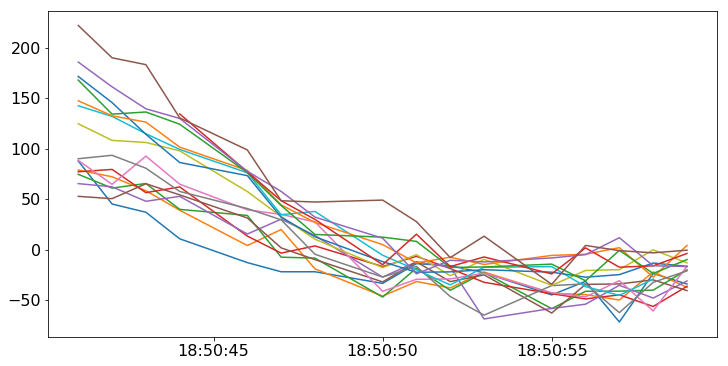

In [26]:
plt.figure(figsize=(12,6))
plt.plot(burst_df)

plt.plot(burst_df.index, linear(34000000, np.array(linearindexes)[:,0],np.array(linearindexes)[:,1]), label="34 MHz")
plt.xlabel("Flux Density [Jy]")
plt.ylabel("Time (s)")
plt.legend()

In [128]:
np.max(linear(34000000, np.array(linearindexes)[:,0],np.array(linearindexes)[:,1]))

790.79092194573775

In [9]:
def powlaw(x,a,b):
    return a*x**b
def linear(x,a,b):
    return a*x+b


In [28]:
from scipy.stats import powerlaw

powerlaw.fit(burst_df.iloc[10][~np.isnan(burst_df.iloc[10])])



(0.26891550438507217, -38.795441943400007, 76.402521343297849)

In [21]:
linearindexes = [curve_fit(linear, 
                           burst_df.loc[i][~np.isnan(burst_df.loc[i])].index.astype(float), 
                           burst_df.loc[i][~np.isnan(burst_df.loc[i])])[0] for i in burst_df.index]

# powlawindexes = [curve_fit(powlaw, 
#                            burst_df.loc[i][~np.isnan(burst_df.loc[i])].index.astype(float), 
#                            burst_df.loc[i][~np.isnan(burst_df.loc[i])], maxfev=10000)[0] for i in burst_df.index]



In [17]:
powlawindexes

NameError: name 'powlawindexes' is not defined

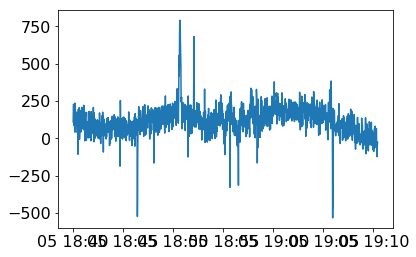

In [108]:
plt.plot(burst_df.index,linear(34000000, np.array(linearindexes)[:,0],np.array(linearindexes)[:,1]))

In [29]:

i = 1
_val = burst_df.iloc[i][~np.isnan(burst_df.iloc[i])]

powlawfit, cov = curve_fit(powlaw, _val.index.astype(float) , _val, maxfev = 100000)
print powlawfit

linearfit = curve_fit(linear, _val.index.astype(float) , _val)[0]
print linearfit


[  4.92237959e+110  -1.39755179e+001]
[ -2.28298268e-05   1.47650837e+03]


powlaw 272807.908603
linear 700.294254477


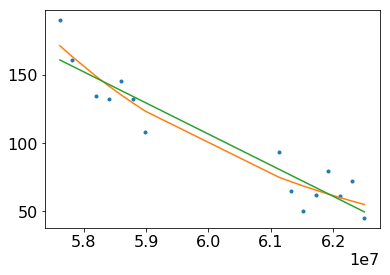

In [33]:
plt.plot(_val.index.astype(float) , _val, ".")

plt.plot(_val.index.astype(float) , 
         powlaw(_val.index.astype(float),powlawfit[0],powlawfit[1]))

plt.plot(_val.index.astype(float) , 
         linear(_val.index.astype(float),linearfit[0],linearfit[1]))

print "powlaw", powlaw(34000000, powlawfit[0], powlawfit[1])
print "linear", linear(34000000, linearfit[0], linearfit[1])

# get TR from database 

In [7]:
engine = 'postgresql'
host = 'ads001'
port = 5432
user = 'mkuiack'
password = 'Morecomplicatedpass1234'
query_loglevel = logging.WARNING



In [8]:
def run_query(transients_query, dbname, dataset_id, engine, host, port, user, pword):
    tkp.db.Database(
        database=dbname, user=user, password=pword,
        engine=engine, host=host, port=port
    )
    
    cursor = tkp.db.execute(transients_query, (dataset_id,))
    transients = tkp.db.generic.get_db_rows_as_dicts(cursor)
    print "Found", len(transients), "new sources"
    return transients


dbname = "TR_20190101"
dataset = 1 #survey_stats[survey_stats.obs == dbname].dataset.values[0]

print "database name: ",  dbname
logging.getLogger('sqlalchemy.engine').setLevel(query_loglevel)

db = tkp.db.Database(engine=engine, host=host, port=port,
                     user=user, password=password, database=dbname)

db.connect()
session = db.Session()

transients_query = """SELECT ex.f_int, ex.f_int_err,ex.f_peak, 
    ex.det_sigma, extract_type, 
    ex.ra, 
    ex.decl, 
    im.band, 
    im.taustart_ts,
    im.freq_eff
    FROM extractedsource ex, image im 
    WHERE ex.id IN ( select xtrsrc FROM assocxtrsource WHERE runcat =  2227) 
    AND ex.image = im.id;
    """
# 89 - reverse DM

TR_data = pd.DataFrame(run_query(transients_query, dbname, dataset, engine, host, port, user, password))

db._configured = False
del db, session

INFO:tkp.db.database:Database config: postgresql://mkuiack@ads001:5432/TR_20190101
INFO:tkp.db.database:connecting to database...


database name:  TR_20190101
Found 22520 new sources


<IPython.core.display.Javascript object>


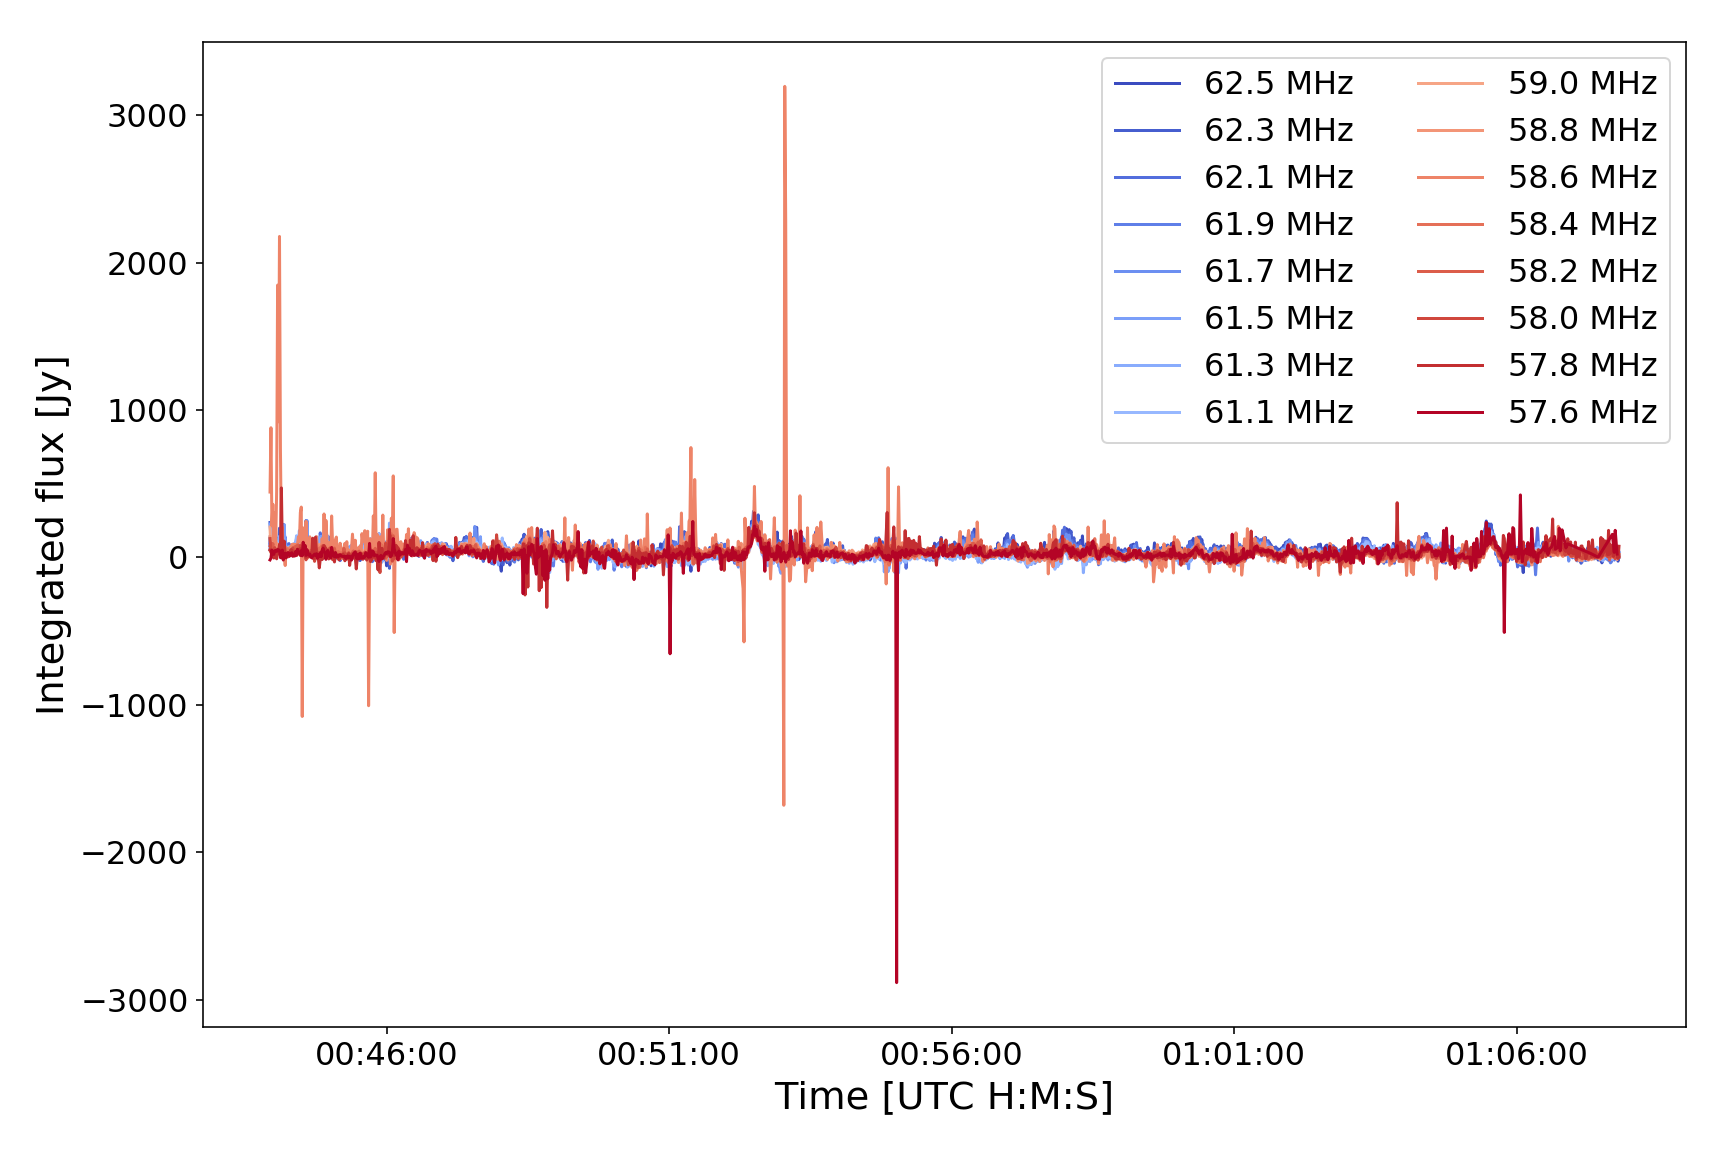

In [9]:
%matplotlib notebook
n_c = 0 





plt.rcParams['font.size']=16
plt.rcParams['axes.labelsize']='large'
plt.rcParams['axes.titlesize']='large'
pylab.rcParams['legend.loc'] = 'best'
matplotlib.rcParams['text.usetex'] = False

all_freq = np.unique(TR_data.freq_eff)
scaled_all_freq = (all_freq - all_freq.min()) / all_freq.ptp()
colors = plt.cm.coolwarm(scaled_all_freq)



n_c = 0 
plt.figure(figsize=(12,8))
for freq in all_freq[::-1]:

    ax = plt.subplot(111)
    burst = TR_data[(TR_data.freq_eff == freq)]# &
#                   (data.taustart_ts > datetime.datetime(year=2016,day=5, month=9, hour=19,minute=0,second=0)) & 
#                   (data.taustart_ts < datetime.datetime(year=2016,day=5, month=9, hour=19,minute=2,second=0))]
    burst.set_index(burst.taustart_ts, inplace=True)
    burst = burst.sort_index()


    xnew = [x.timestamp() for x in burst.taustart_ts]
    xaxis = [datetime.datetime.utcfromtimestamp(x) for x in xnew]

    ax.plot(xaxis, burst.f_int , c=colors[n_c], label="{} MHz".format(round(freq/1e6,1)))

    n_c += 1


myFmt = mdates.DateFormatter('%H:%M:%S')
ax.xaxis.set_major_formatter(myFmt)
#     ax.set_ylim([-100,200])
plt.ylabel("Integrated flux [Jy]")
plt.legend(ncol=2)
# plt.title(_ID)
plt.xlabel("Time [UTC H:M:S]")
plt.tight_layout()
plt.show()

<IPython.core.display.Javascript object>


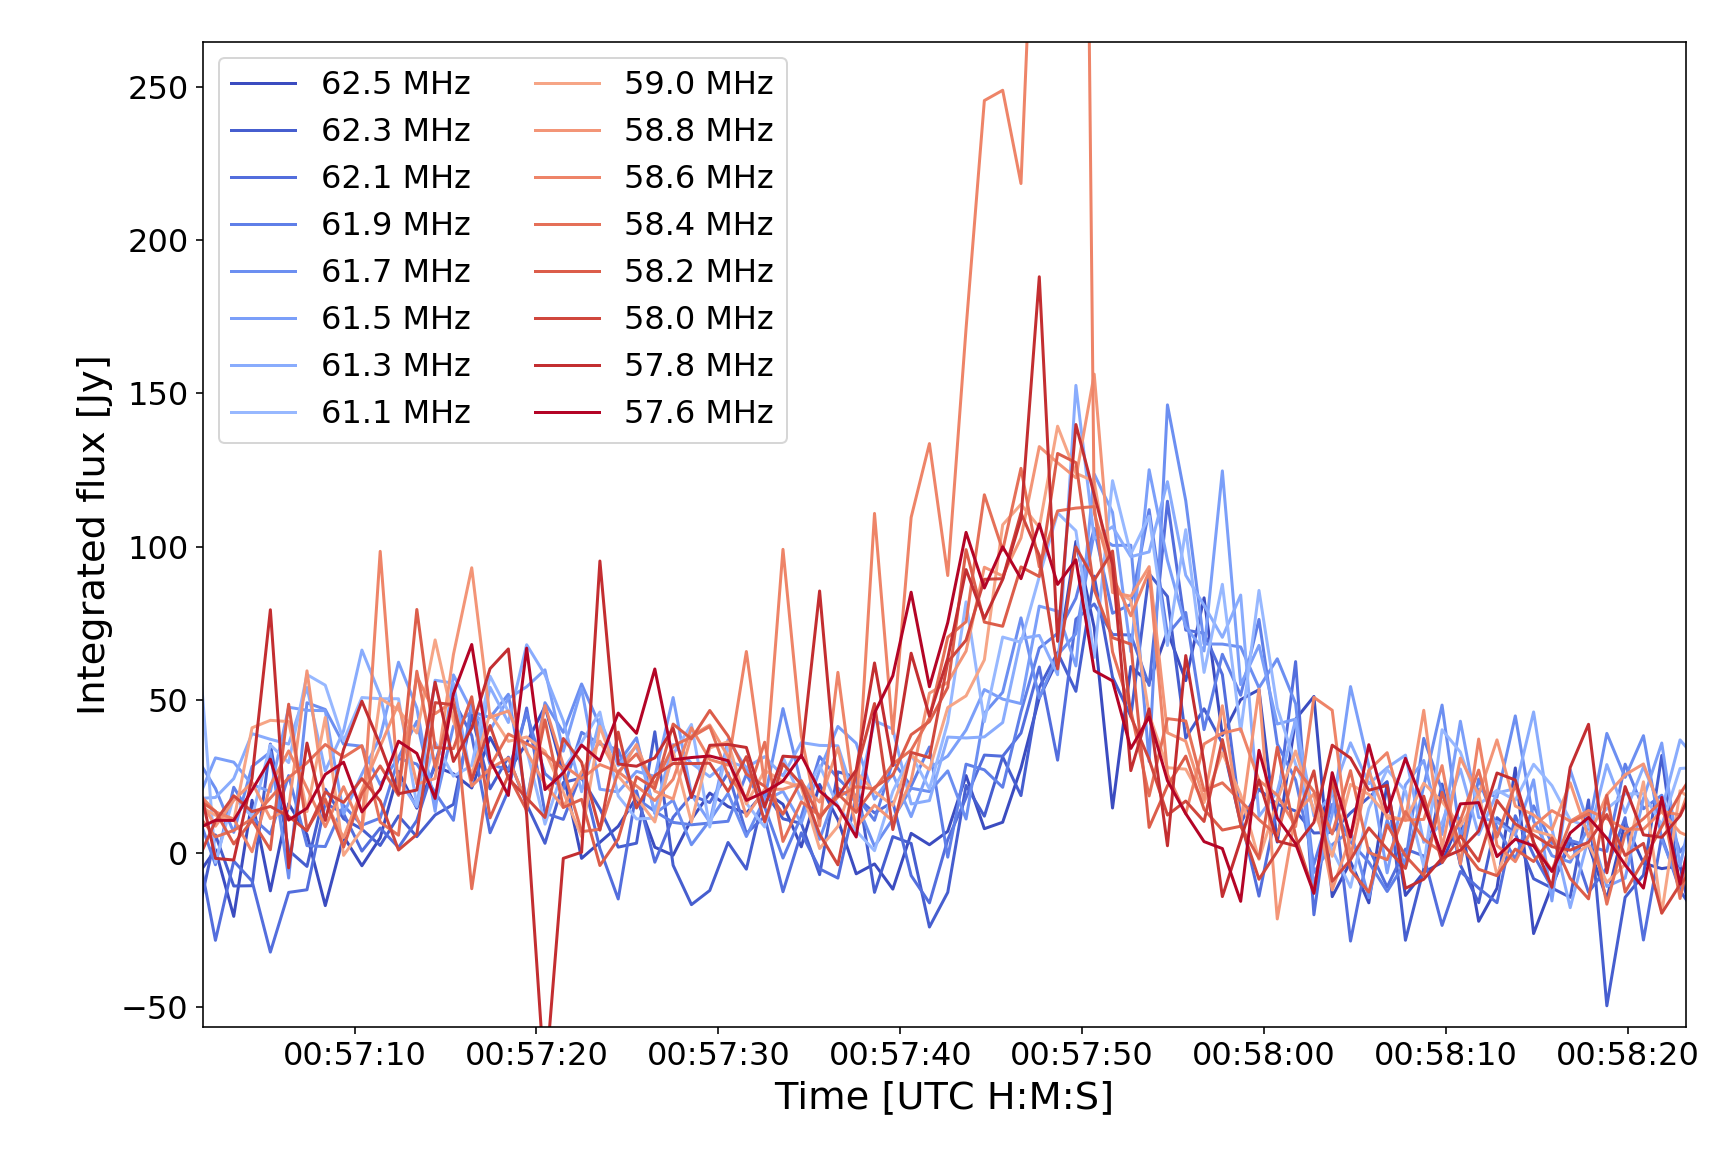

In [21]:
%matplotlib notebook
n_c = 0 





plt.rcParams['font.size']=16
plt.rcParams['axes.labelsize']='large'
plt.rcParams['axes.titlesize']='large'
pylab.rcParams['legend.loc'] = 'best'
matplotlib.rcParams['text.usetex'] = False

all_freq = np.unique(TR_data.freq_eff)
scaled_all_freq = (all_freq - all_freq.min()) / all_freq.ptp()
colors = plt.cm.coolwarm(scaled_all_freq)



n_c = 0 
plt.figure(figsize=(12,8))
for freq in all_freq[::-1]:

    ax = plt.subplot(111)
    burst = TR_data[(TR_data.freq_eff == freq)]# &
#                   (data.taustart_ts > datetime.datetime(year=2016,day=5, month=9, hour=19,minute=0,second=0)) & 
#                   (data.taustart_ts < datetime.datetime(year=2016,day=5, month=9, hour=19,minute=2,second=0))]
    burst.set_index(burst.taustart_ts, inplace=True)
    burst = burst.sort_index()


    xnew = [x.timestamp() for x in burst.taustart_ts]
    xaxis = [datetime.datetime.utcfromtimestamp(x) for x in xnew]

    ax.plot(xaxis, burst.f_int , c=colors[n_c], label="{} MHz".format(round(freq/1e6,1)))

    n_c += 1


myFmt = mdates.DateFormatter('%H:%M:%S')
ax.xaxis.set_major_formatter(myFmt)
#     ax.set_ylim([-100,200])
plt.ylabel("Integrated flux [Jy]")
plt.legend(ncol=2)
# plt.title(_ID)
plt.xlabel("Time [UTC H:M:S]")
plt.tight_layout()
plt.show()